## TC3007B
### Word Embeddings

#### Karen Cebreros López - A01704254
#### Fermín Méndez García - A01703366
#### Emiliano Vásquez Olea - A01707035
#### Diego Emilio Barrera Hdz - A01366802
#### José Ángel García López - A01275108


<br>

#### Activity 2: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

# These libraries are suggested to plot confusion matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import gc

/Users/karencl/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
# Obtenemos los datos
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [5]:
# Hacemos los tokens
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Creamos el vocabulario
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])

# Ponemos el 'unknown token' en la posición 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
# Prueba de los tokens
tokens = tokeniser('Welcome to TC3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc3007'] [3314, 4, 0]


In [8]:
# Se divide el tamaño de "train_dataset" para hacer el split
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
# Se hace el "random_split" de "train_dataset" para obtener el dataset de validación y entrenamiento
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
# Tamaño de cada conjunto
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [11]:
def collate_batch(batch):
    ''' Función para procesar batches
    Args:
        batch - batch de datos a procesar
    Return:
        etiquetas preparadas en un rango de 0-3
    '''
    # Obtenemos el texto y la etiqueta
    y, x = list(zip(*batch))
    
    # Se crea un arreglo de los índices de tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Se preparan las etiquetas
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [12]:
labels =  ["World", "Sports", "Business", "Sci/Tech"] # Etiquetas
max_tokens = 50 # Num máximo de tokens
BATCH_SIZE = 256 # Tamaño de batch

In [13]:
# Hacemos los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [14]:
EMBEDDING_SIZE = 300 # Tamaño del los embeddings
NEURONS = 256 # Número de neuronas
LAYERS = 2 # Cantidad de capas
NUM_CLASSES = 4 # Cantidad de clases (etiquetas)

In [20]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, num_classes, vocab_size):
        super(RNN_Model_1, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        
        # LSTM 
        self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        # Capa lineal (fully connected)
        self.fc = nn.Linear(hidden_size, num_classes)
    
        
    def forward(self, x):
        # Se sacan los embeddings
        embedds = self.embedding_layer(x)
        # Se pasa el input a la capa rnn
        output, _ = self.rnn(embedds)
        # Se toma solamente el output del último time_step
        output = output[:, -1, :]
        # Y al final se pasa ese output a la capa lineal "fully connected"
        decoded = self.fc(output)
        return decoded

In [16]:
def accuracy(model, loader):
    ''' Función para obtener la precisión
    Args:
        model - modelo creado
        loader - DataLoader que se pasa para obtener su precisión con el modelo
    '''  
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
            
    # Se deshabilita el cálculo del gradiente
    with torch.no_grad():
        # Se itera sobre los batches del loader
        for x, y in loader:
            x = x.to(device=device, dtype=torch.long)
            y = y.to(device=device, dtype=torch.long)

            # Se generan los scores
            scores = model(x)
            # Y a través de ello las prediciones
            _, preds = scores.max(dim = 1)

            # Se obtiene el total de predicciones correctas y la cantidad total de predicciones
            num_correct += (preds == y).sum()
            num_total += preds.size(0)
        
        # Se obtiene la precisión y se regresa
        acc = float(num_correct) / num_total
        return acc

In [17]:
def train(model, optimiser, epochs=100):
    ''' Función para el entrenamiento del modelo
    Args:
        model - modelo creado
        optimiser - optimiser
        epochs - número de épocas (en caso de que no se especifique, habrán 100 épocas)
    '''         
    model = model.to(device=device)
    
    # Se itera sobre el número de épocas
    for epoch in range(epochs):
        # Se itera sobre los batches del train_loader
        for i, (x, y) in enumerate(tqdm(train_loader)):
            model.train()
            x = x.to(device=device, dtype=torch.long)
            y = y.to(device=device, dtype=torch.long)

            # Se generan los scores
            scrores = model(x)          
            # Se calcula el costo
            cost = F.cross_entropy(input=scrores, target=y)
            
            # Reset the gradient
            optimiser.zero_grad()
            # Compute the gradients
            cost.backward()
            # Update parameters
            optimiser.step()
        
        # Se obtiene la precisión con el val_loader
        acc = accuracy(model, val_loader)
        # Imprimimos la información útil y necesaria del entrenamiento del modelo
        print(f'Epoch: {epoch}, Cost: {cost.item():.4f}, Acc: {acc:.4f}')

In [23]:
epochs = 5 # Número de épocas
lr = 0.0005 # Learning rate

# Se instancia el modelo
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES, len(vocab))

optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr) # Optimiser


In [24]:
# Se manda a llamar la función "train" para entrenar el modelo
train(rnn_model, optimiser=optimiser,  epochs=epochs)

100%|██████████| 422/422 [01:56<00:00,  3.62it/s]


Epoch: 0, Cost: 0.5301, Acc: 0.8680


100%|██████████| 422/422 [01:58<00:00,  3.57it/s]


Epoch: 1, Cost: 0.2166, Acc: 0.8940


100%|██████████| 422/422 [02:00<00:00,  3.51it/s]


Epoch: 2, Cost: 0.2077, Acc: 0.9058


100%|██████████| 422/422 [01:59<00:00,  3.52it/s]


Epoch: 3, Cost: 0.1968, Acc: 0.9124


100%|██████████| 422/422 [01:58<00:00,  3.56it/s]


Epoch: 4, Cost: 0.1321, Acc: 0.9124


In [25]:
# Precisión del test_loader
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.9067


In [27]:
def sample_text(model, loader):
    '''  Función que toma un texto como entrada y lo clasifica usando el modelo ya entrenado
    Args:
        model - nuestro modelo ya entrenado
        loader - texto ya preprocesado
    Returns:
        predictions - predicciones de la clasificación del texto
        labels - las etiquetas reales del texto
    '''
    model.eval() 
    predictions = []
    labels = []

    # Se deshabilita el cálculo del gradiente
    with torch.no_grad():
         # Se itera sobre los batches de loader
         for x, y in loader:
            x = x.to(device=device, dtype=torch.long)
            y = y.to(device=device, dtype=torch.long)

            # Se generan los scores
            scores = model(x)

            # Convierte los scores en probabilidades (usando softmax)
            probabilities = torch.softmax(scores, dim=1)
            # Luego se elige la clase más probable a partir de lo anterior
            preds = torch.argmax(probabilities, dim=1)

            # Se juntan las predicciones (preds) y aparte las etiquetas (y) para devolverlas
            predictions.extend(preds.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return predictions, labels

In [28]:
# Se manda a llamar "sample_text" con test loader y nuestro modelo
predictions, labels = sample_text(rnn_model, test_loader)

In [29]:
def confusion_matrix(predictions, labels):
    ''' Función que crea una matriz de confusión
    Args:
        predictions - predicciones de la clasificación del texto
        labels - las etiquetas reales del texto
    '''
    plt.figure(figsize=(10, 10))
    # Se calcula la matriz de confusión
    skplt.metrics.plot_confusion_matrix(labels, predictions)

    # Se muestra la matriz de confusión
    plt.show()

<Figure size 1000x1000 with 0 Axes>

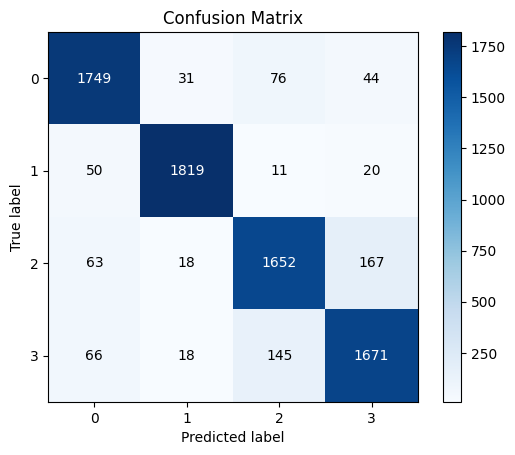

In [30]:
# Se manda a llamar "confusion_matrix" para obtener y graficar la matriz de confusión
confusion_matrix(predictions, labels)